In [5]:
import torch
import torch.nn as nn
from src.networks import MAGANet  # Replace with your actual model import
from src.args import Args
from src.dataset import DspritesDataset, get_dataloaders_2element
import matplotlib.pyplot as plt

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH ="../outputs/run_dev_maga/seed_1_240320250829/models/model_2element.pth"

In [7]:
# Load the model

args  = Args(file="../data/configs/default.yaml")
model = MAGANet(args).to(device)  # Adjust parameters as per your model
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

MAGANet(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=20, bias=True)
    )
  )
  (decoder): FlowNet(
    (affine): Affine(
      (fc_M): Linear(in_features=10, out_features=4096, bias=True)
    )
    (flow_modules): Sequential(
      (0): FlowModule(
        (squeeze): SqueezeLayer()
        (flow_steps): Sequential(
          (0): FlowStep(
            (act_norm): ActNorm()
  

In [8]:
# Dictionary to store intermediate outputs
intermediate_outputs = {}

# Hook function to capture outputs
def get_activation(name):
    def hook(module, input, output):
        intermediate_outputs[name] = output
    return hook

# Attach hooks to the desired layers
# Affine layer
model.decoder.affine.register_forward_hook(get_activation('affine'))

# Flow modules and their subcomponents
for i, flow_module in enumerate(model.decoder.flow_modules):
    flow_module.register_forward_hook(get_activation(f'flow_module_{i}'))
    for j, flow_step in enumerate(flow_module.flow_steps):
        flow_step.register_forward_hook(get_activation(f'flow_module_{i}_step_{j}'))
        flow_step.act_norm.register_forward_hook(get_activation(f'flow_module_{i}_step_{j}_actnorm'))
        flow_step.inv_conv.register_forward_hook(get_activation(f'flow_module_{i}_step_{j}_invconv'))
        flow_step.coupling.register_forward_hook(get_activation(f'flow_module_{i}_step_{j}_coupling'))

# Encoder convolutional layers
for i, layer in enumerate(model.encoder.conv):
    layer.register_forward_hook(get_activation(f'encoder_conv_{i}'))

In [9]:
def capture_latents(model, x1, x2):
    with torch.no_grad():
        z, mu1, logvar1, mu2, logvar2 = model.encoder(x1, x2)
        z1 = model.encoder.sample_z(mu1, logvar1)  # Sample z1
        z2 = model.encoder.sample_z(mu2, logvar2)  # Sample z2
        return z, z1, z2

In [10]:
def visualize_image_output(output, name):
    
    if isinstance(output, tuple):
        output = output[0]

    if output.dim() == 4:  # [B, C, H, W]
        plt.figure(figsize=(15, 3))
        num_channels = min(5, output.size(1))  # Show up to 5 channels
        for i in range(num_channels):
            plt.subplot(1, num_channels, i + 1)
            plt.imshow(output[0, i].cpu().detach().numpy(), cmap='gray')
            plt.title(f'{name} Ch{i}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cannot visualize {name}: unexpected shape {output.shape}")

In [11]:
def visualize_latent(z, name):
    plt.figure(figsize=(8, 4))
    z = z.cpu().detach().numpy()
    if z.ndim == 1:  # Single vector
        plt.bar(range(len(z)), z)
    elif z.ndim == 2:  # Batch of vectors
        plt.hist(z.flatten(), bins=30)
    plt.title(name)
    plt.xlabel('Dimension' if z.ndim == 1 else 'Value')
    plt.ylabel('Value' if z.ndim == 1 else 'Frequency')
    plt.show()

In [12]:
def visualize_model_outputs(model, x1, x2):
    # Clear previous outputs
    intermediate_outputs.clear()
    print("Provided Input: ")
    visualize_image_output(x1, 'x1')
    # Run the forward pass
    with torch.no_grad():
        z, mu1, logvar1, mu2, logvar2, decoded_x1, decoded_x2 = model(x1, x2)  # Standard forward pass
        print('x2: ', decoded_x2.shape)
        z, z1, z2 = capture_latents(model, x1, x2)  # Capture latent vectors

    print(z2.shape)

    # Visualize encoder convolutional outputs
    print("Encoder Convolutional Outputs:")
    for key in sorted([k for k in intermediate_outputs.keys() if k.startswith('encoder_conv_')]):
        visualize_image_output(intermediate_outputs[key], key)

    # Visualize latent vectors
    print("Latent Vectors:")
    visualize_latent(z1, 'z1')
    visualize_latent(z2, 'z2')
    visualize_latent(z, 'z (z2 - z1)')

    # Visualize decoder outputs
    print("Decoder Outputs:")
    # Affine layer
    visualize_image_output(intermediate_outputs.get('affine'), 'affine')

    # Flow modules and their subcomponents
    for key in sorted(intermediate_outputs.keys()):
        if key.startswith('flow_module_'):
            if 'step' not in key and 'actnorm' not in key and 'invconv' not in key and 'coupling' not in key:
                visualize_image_output(intermediate_outputs[key], key)  # Flow module output
            elif 'step' in key and 'actnorm' not in key and 'invconv' not in key and 'coupling' not in key:
                visualize_image_output(intermediate_outputs[key], key)  # Flow step output
            elif 'actnorm' in key:
                visualize_image_output(intermediate_outputs[key], key)  # ActNorm output
            elif 'invconv' in key:
                visualize_image_output(intermediate_outputs[key], key)  # Invertible1x1Conv output
            elif 'coupling' in key:
                visualize_image_output(intermediate_outputs[key], key)  # AdditiveCoupling output

    # Optionally visualize the final generated image
    print("Generated Output:")
    visualize_image_output(decoded_x2, 'decoded_x2')

In [13]:
single_output = False
# Load dataset with the correct output format
train_data = DspritesDataset("../data/2d/train.npz", single_output=single_output)
test_data = DspritesDataset("../data/2d/test.npz", single_output=single_output)

# Choose the correct data loader function
if  "maga" in args.model_name:
    train_loader, test_loader = get_dataloaders_2element(
        train_data, test_data,
        batch_size=1
    )

    

In [14]:
for x1, x2 in train_loader:
    x1_image, x2_image = x1.to(device), x2.to(device)
    break

print(x1_image)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


Provided Input: 


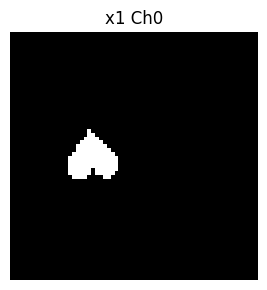

x2:  torch.Size([1, 1, 64, 64])
torch.Size([1, 10])
Encoder Convolutional Outputs:


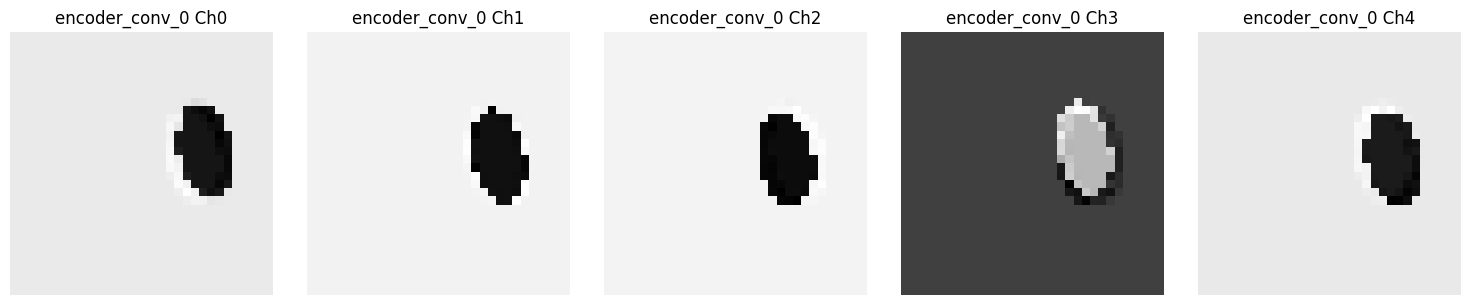

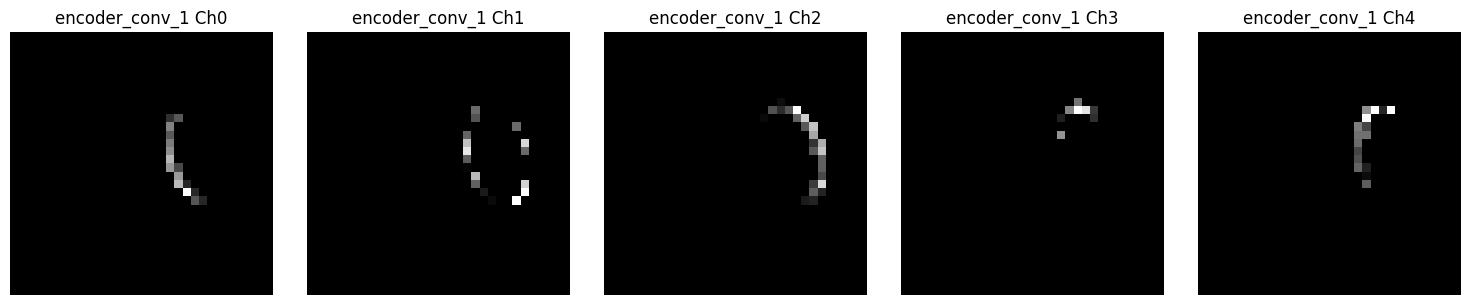

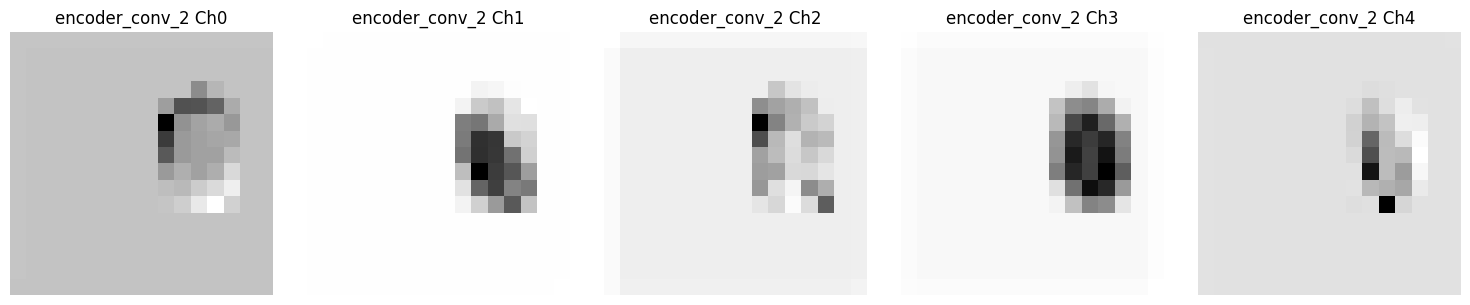

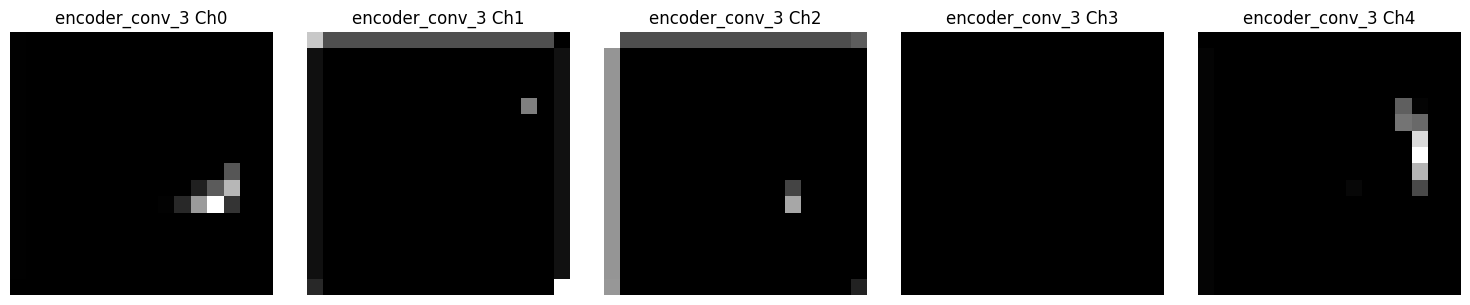

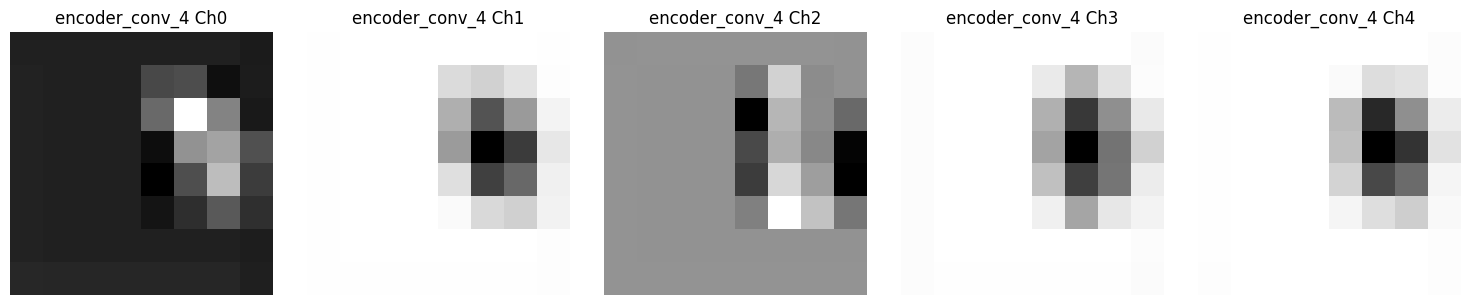

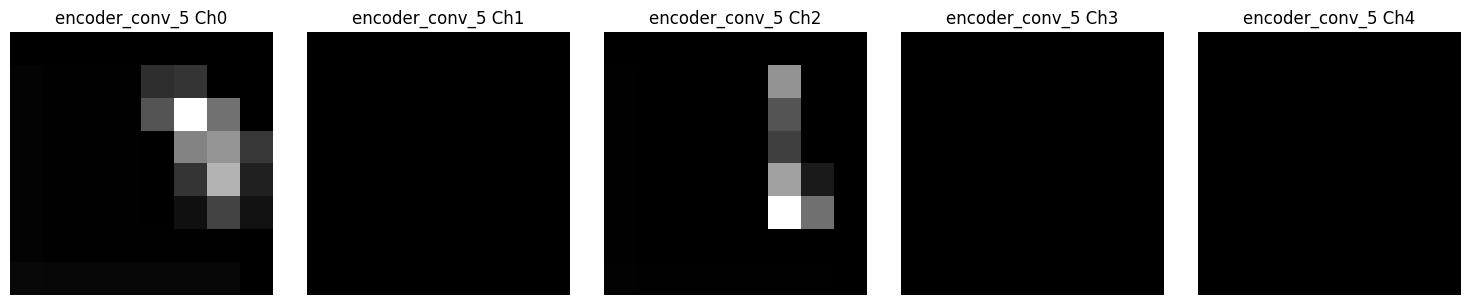

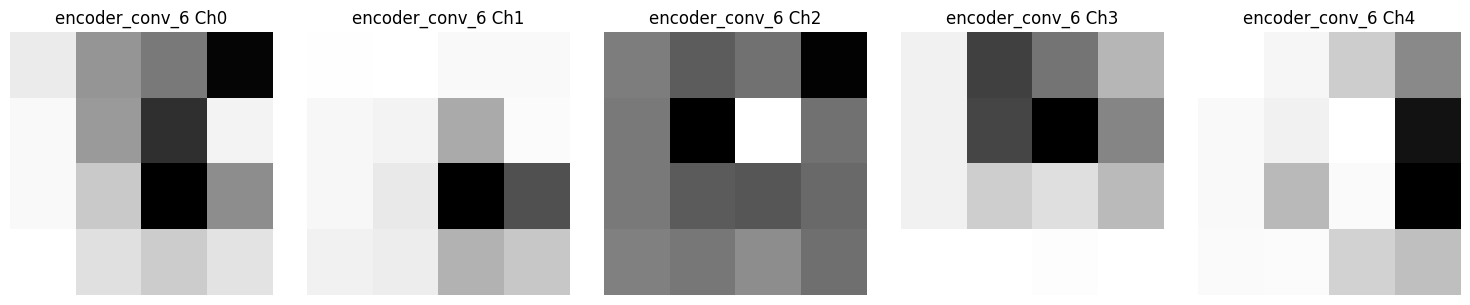

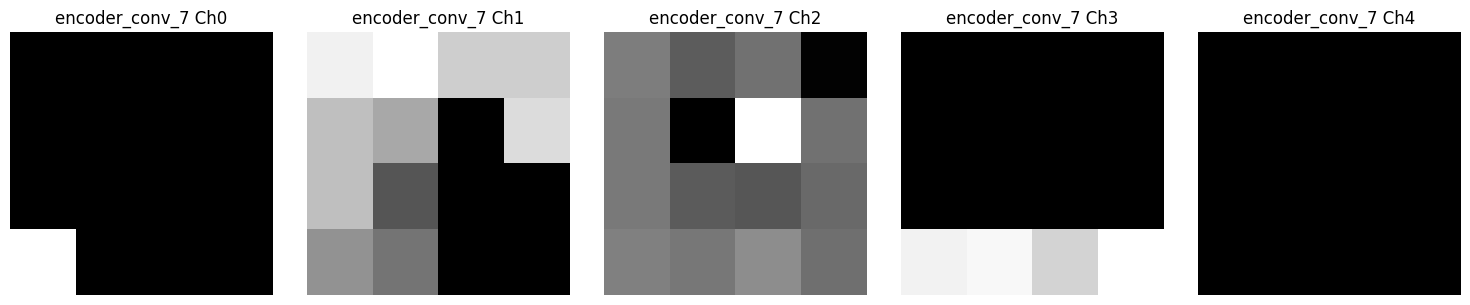

Latent Vectors:


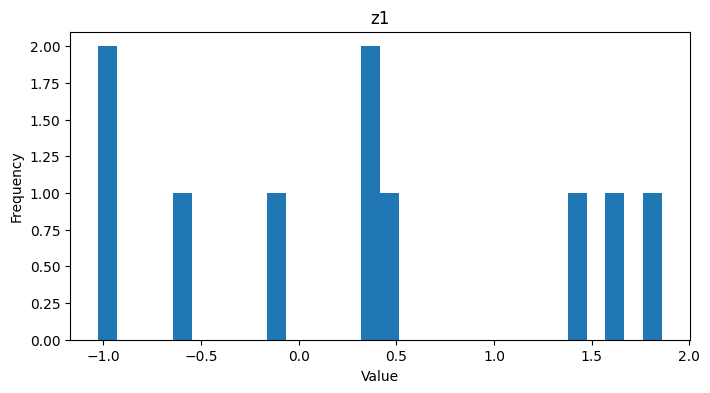

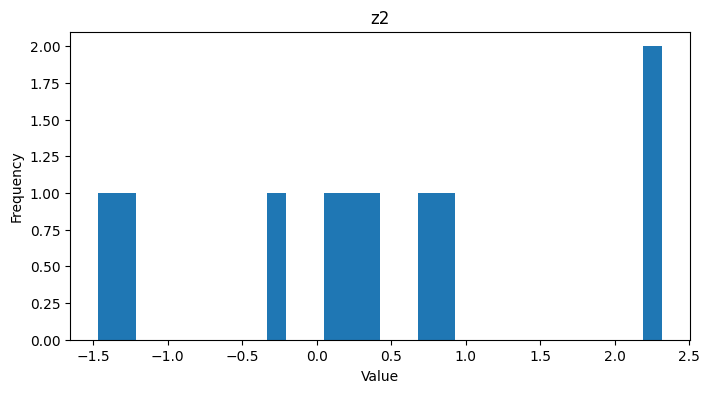

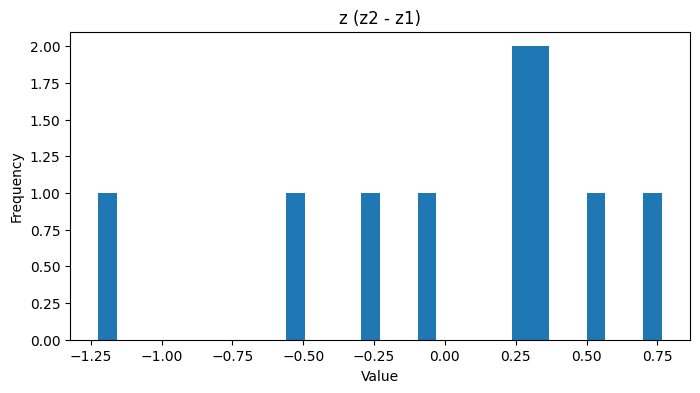

Decoder Outputs:


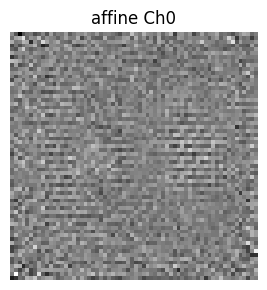

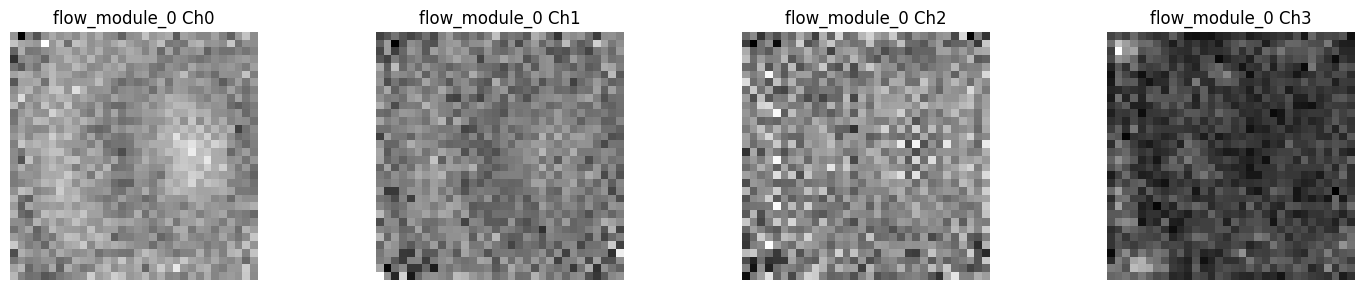

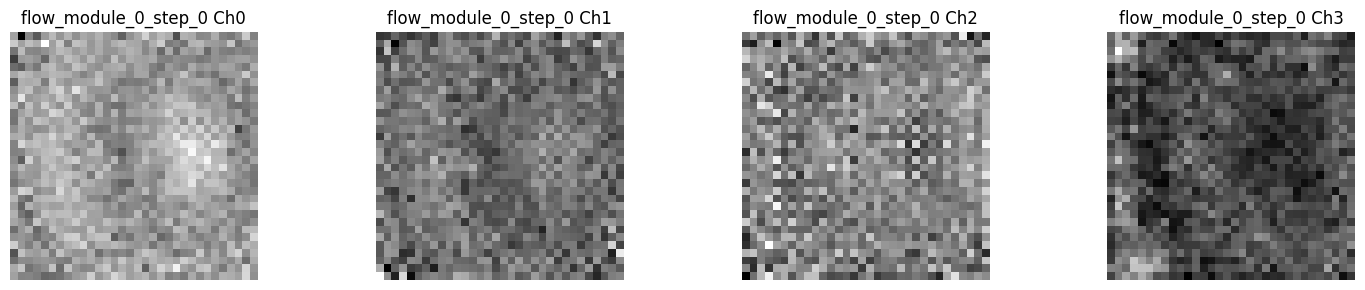

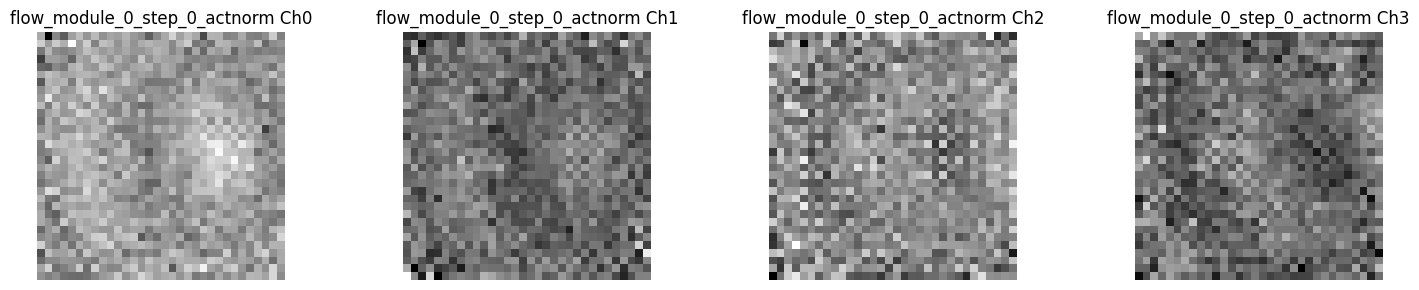

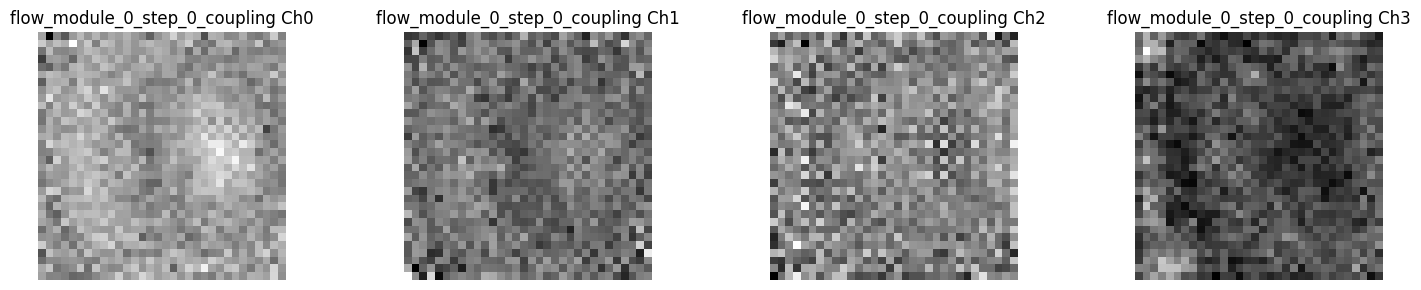

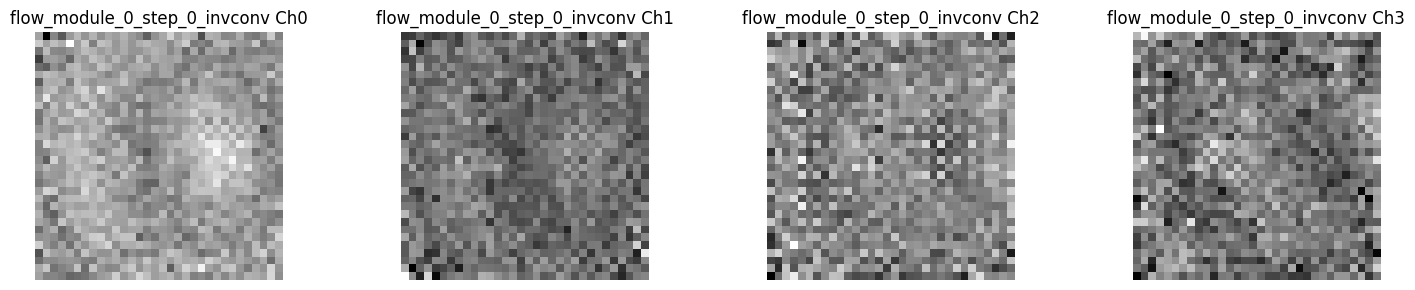

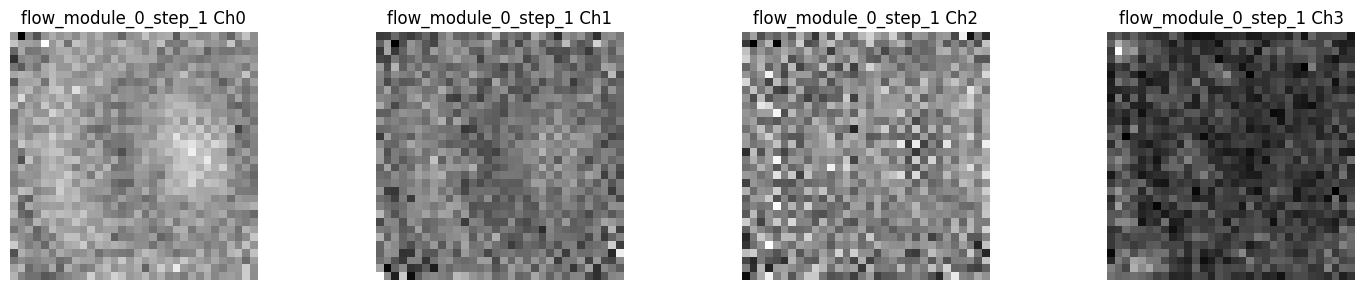

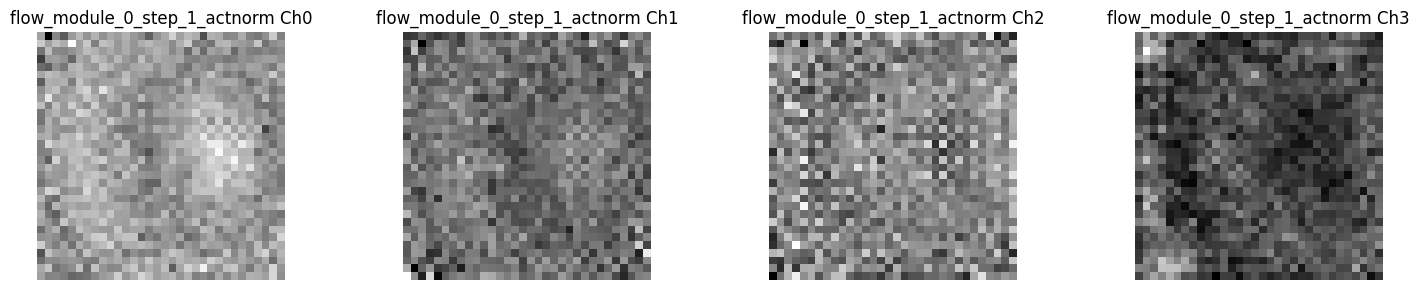

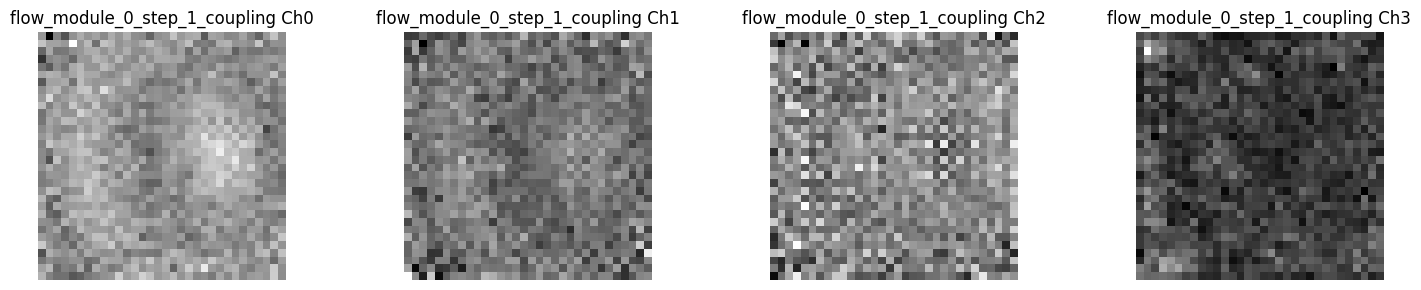

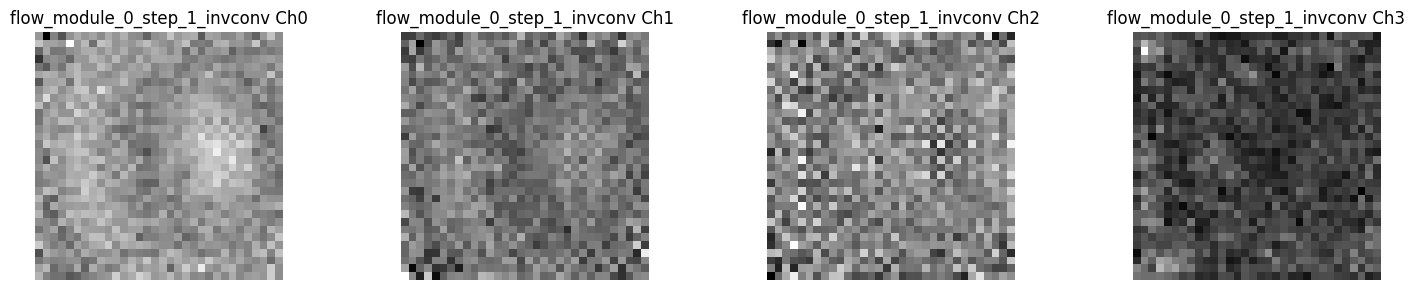

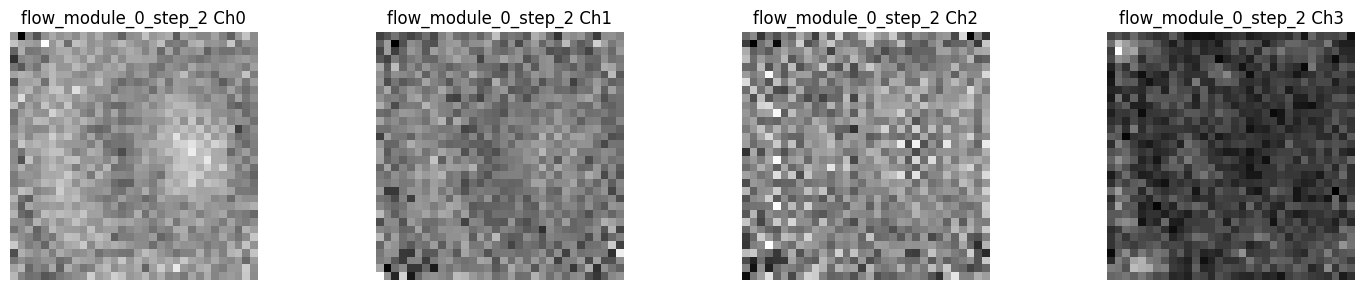

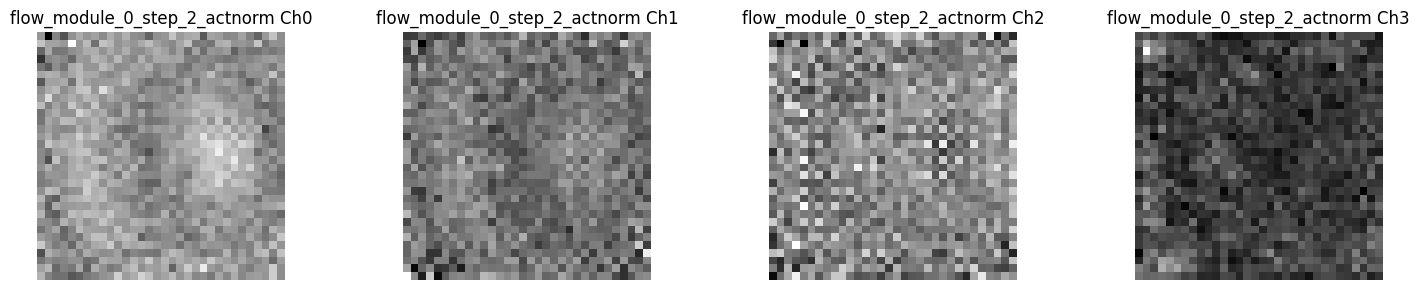

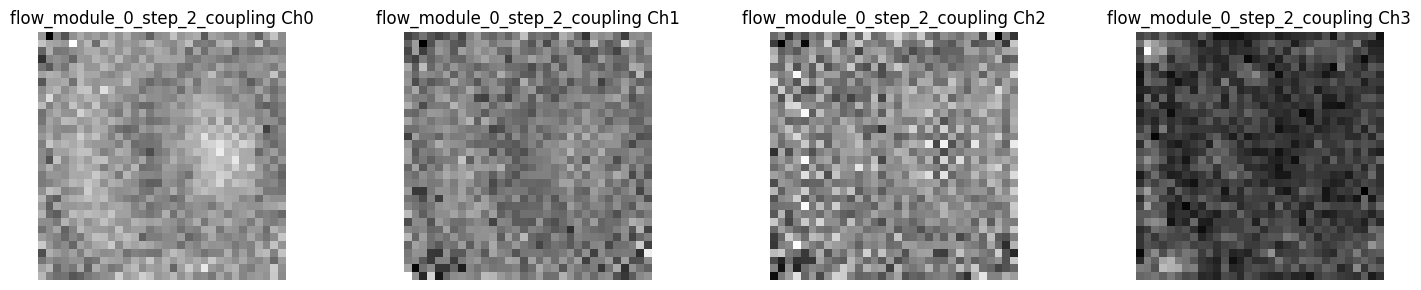

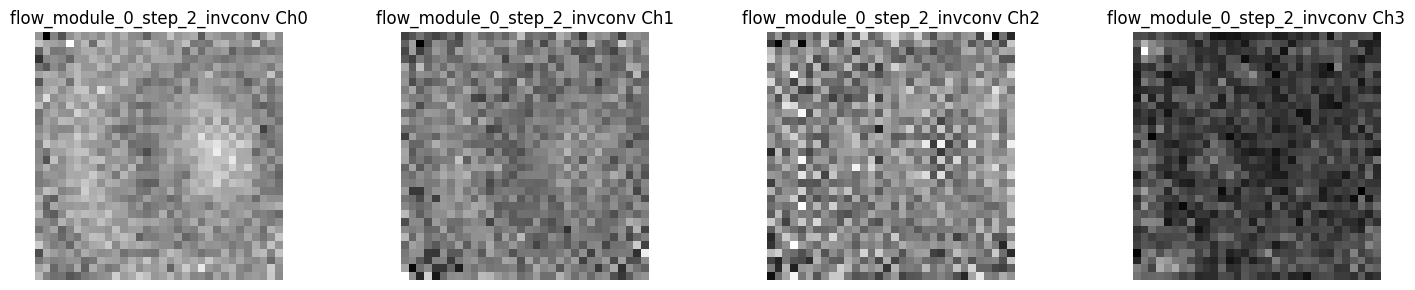

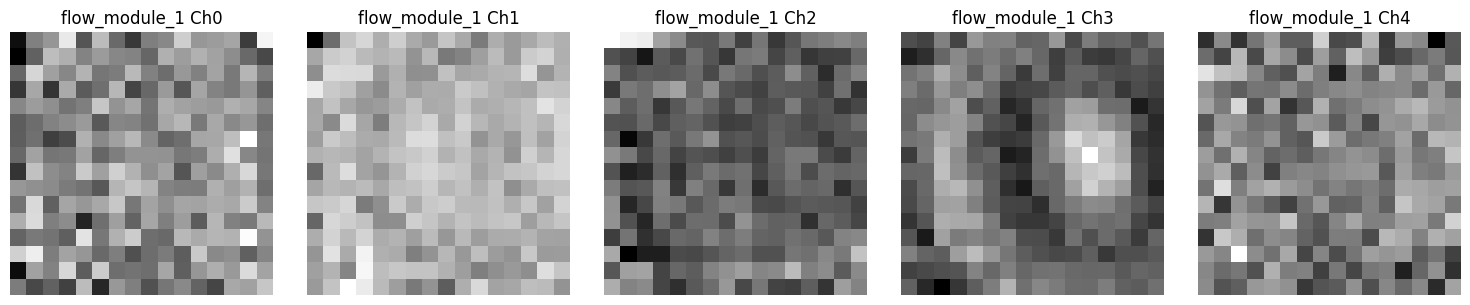

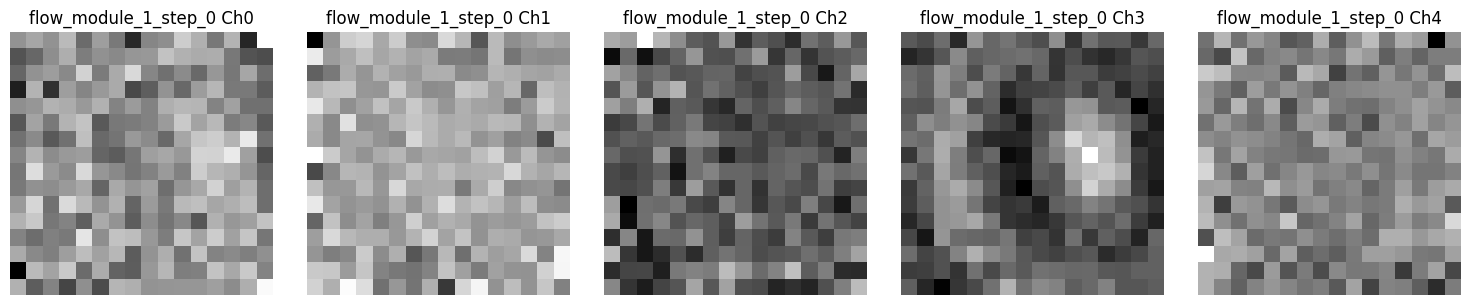

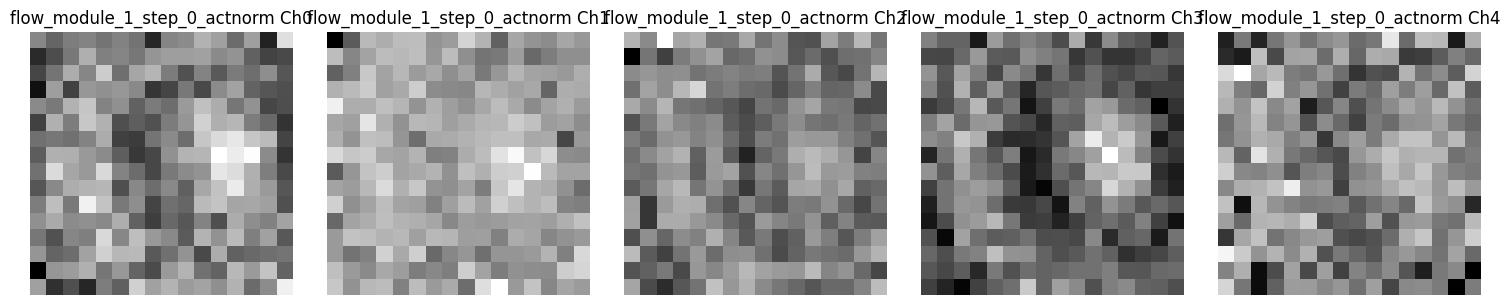

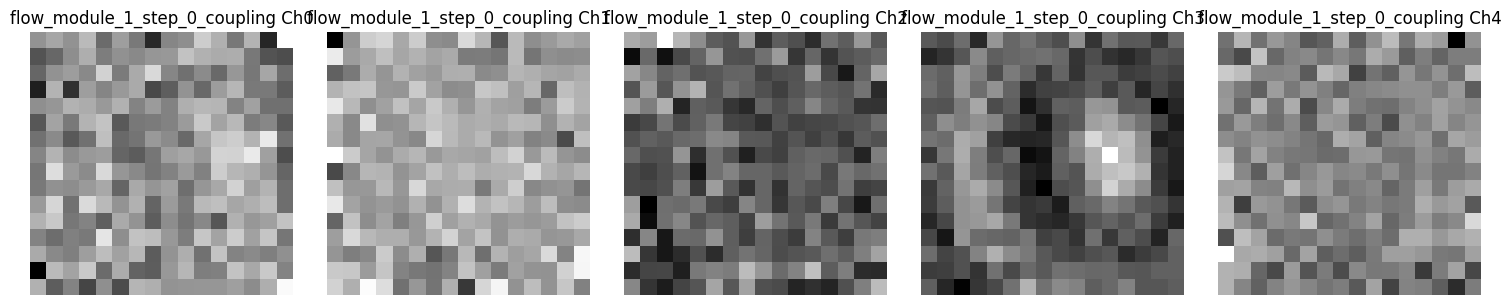

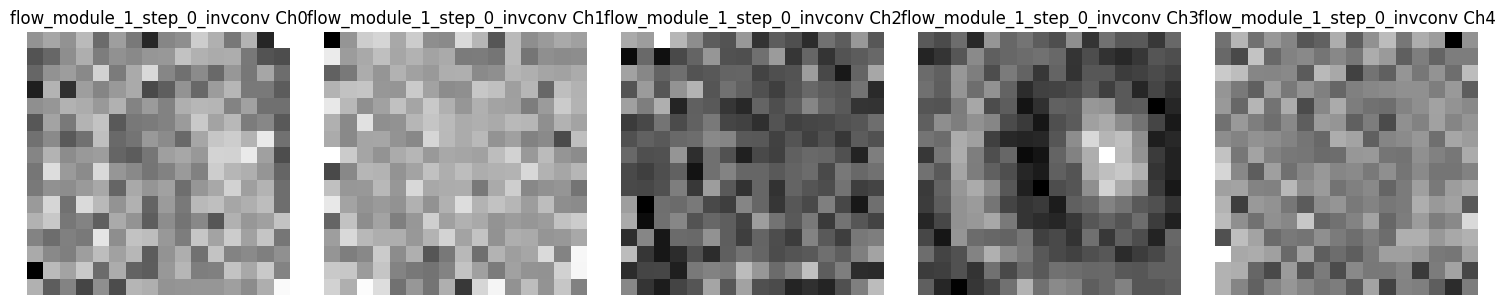

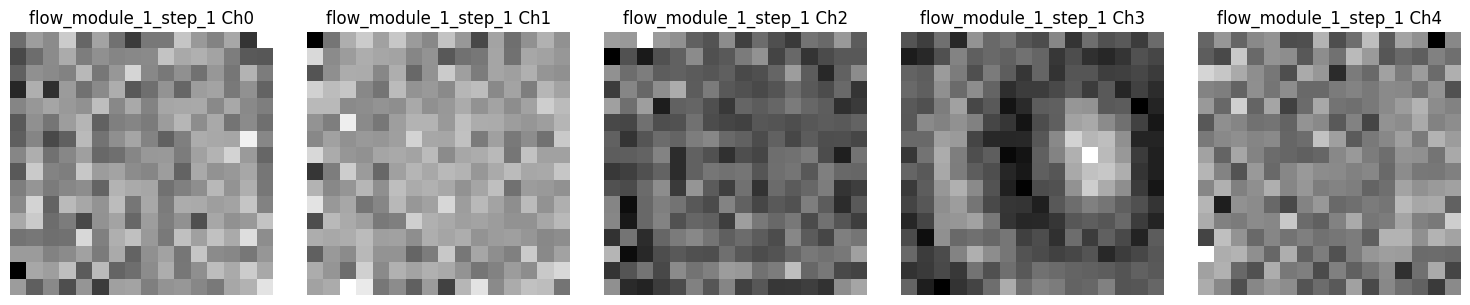

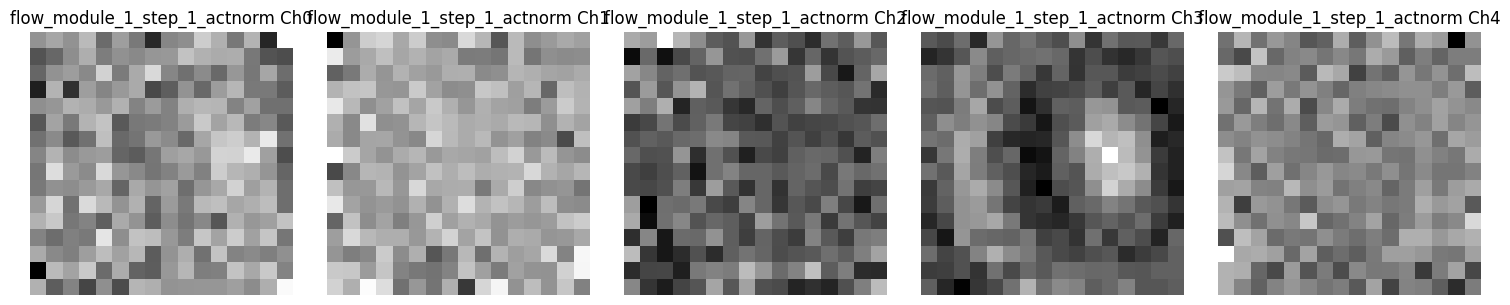

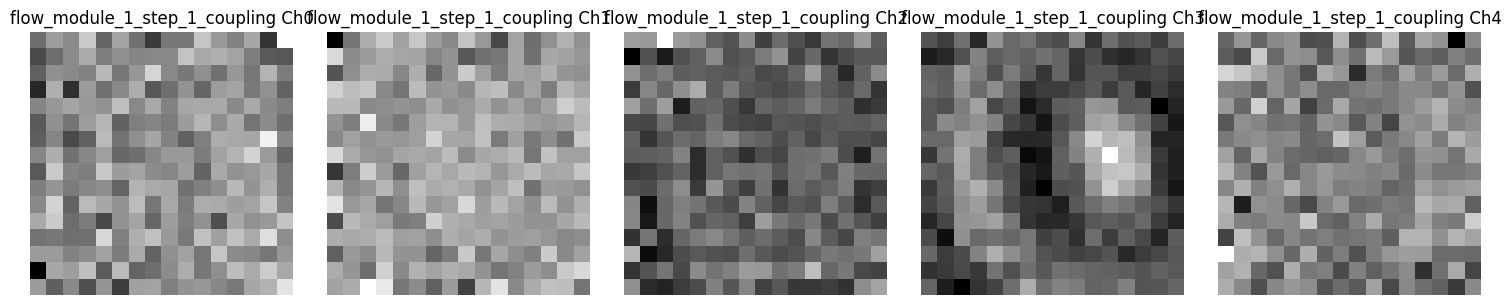

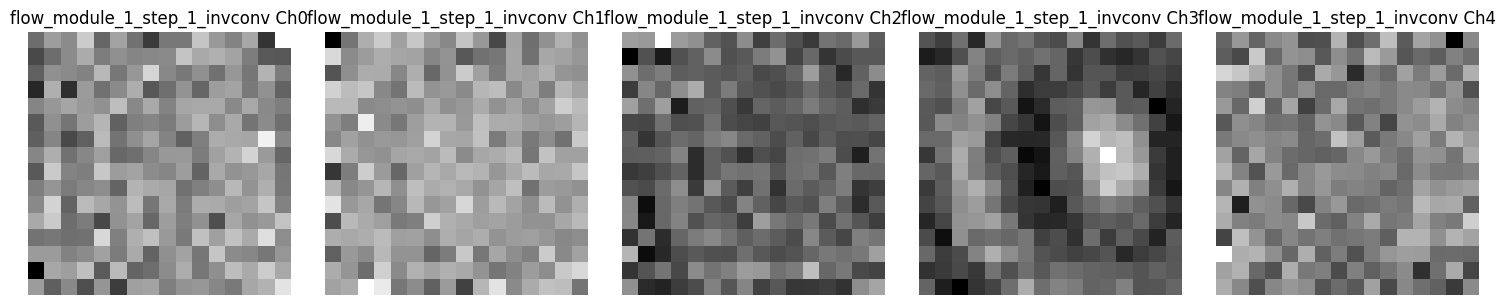

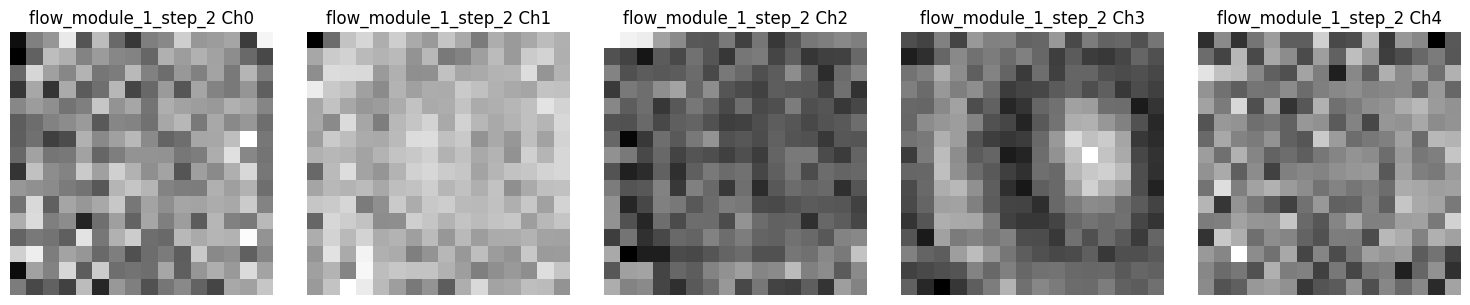

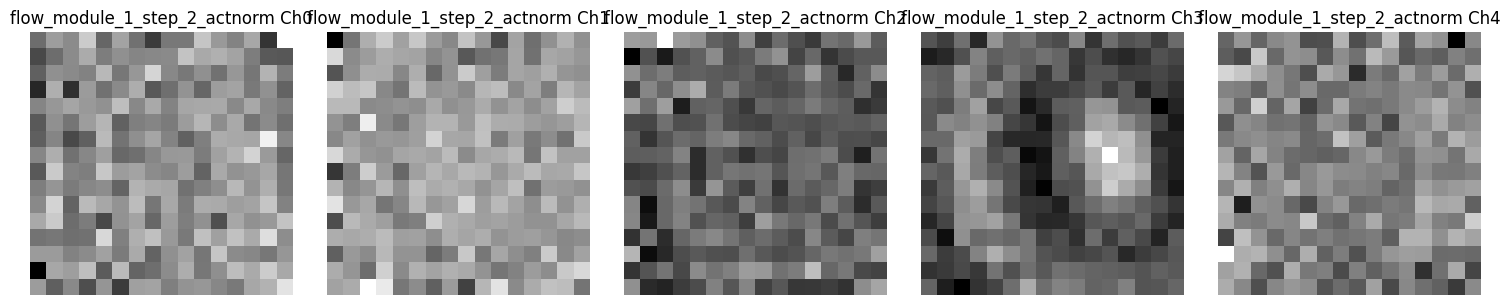

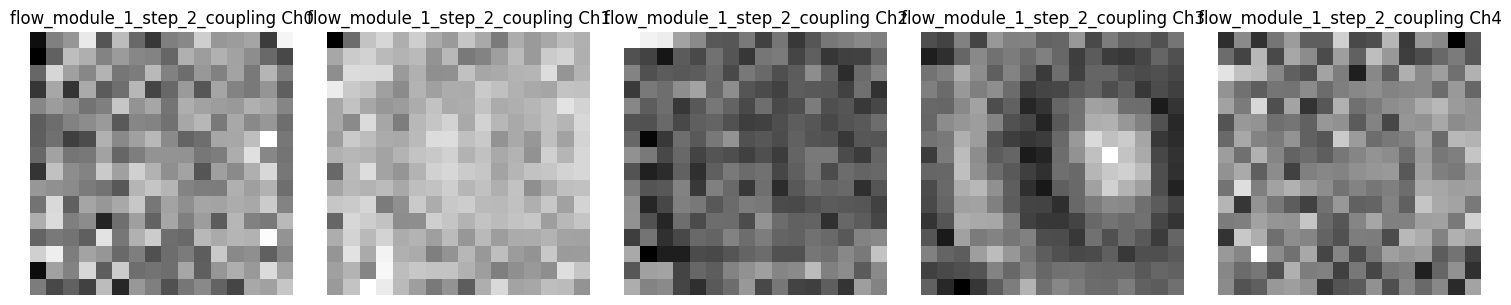

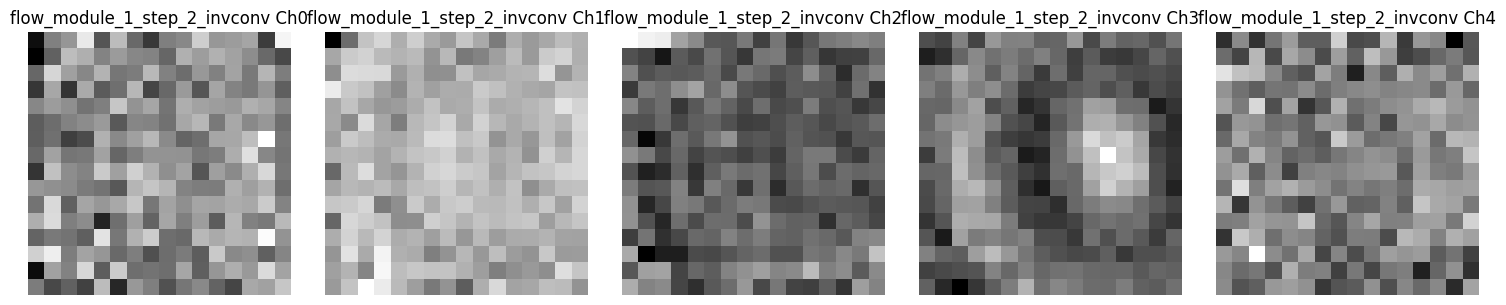

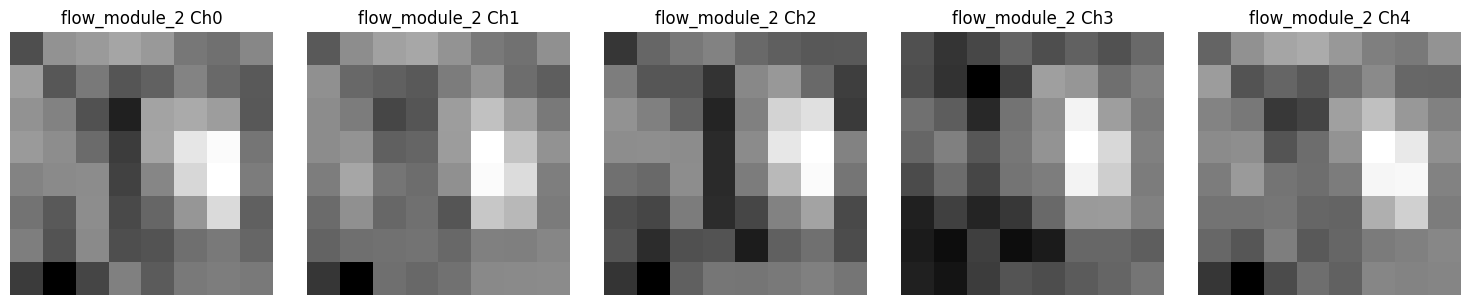

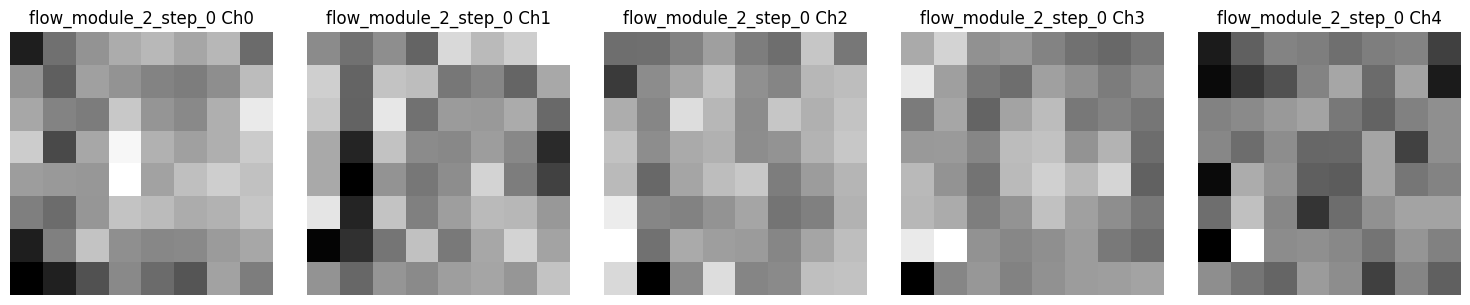

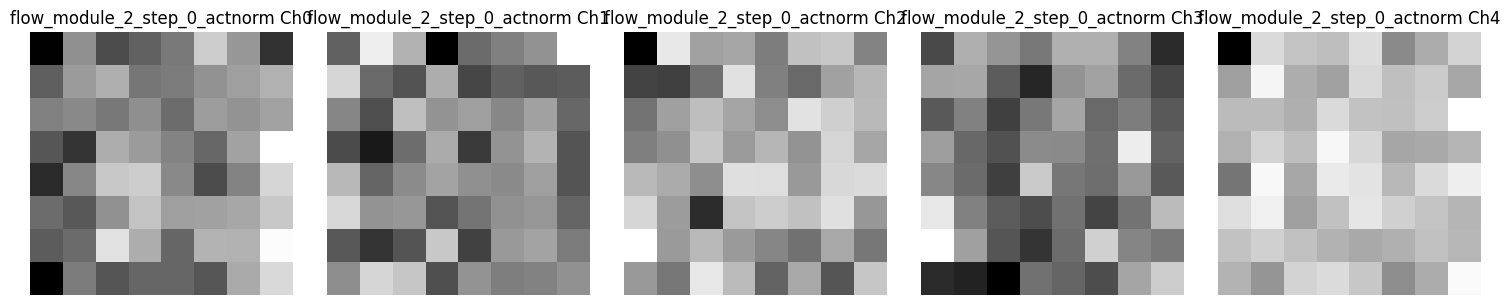

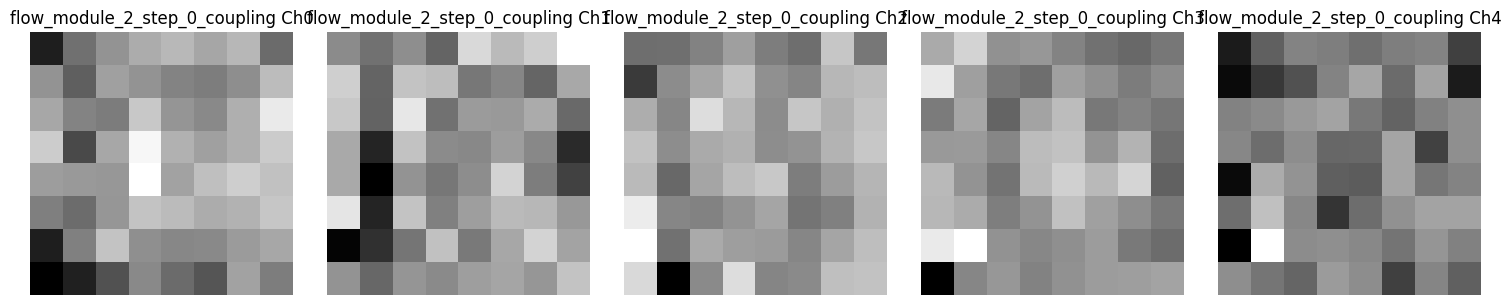

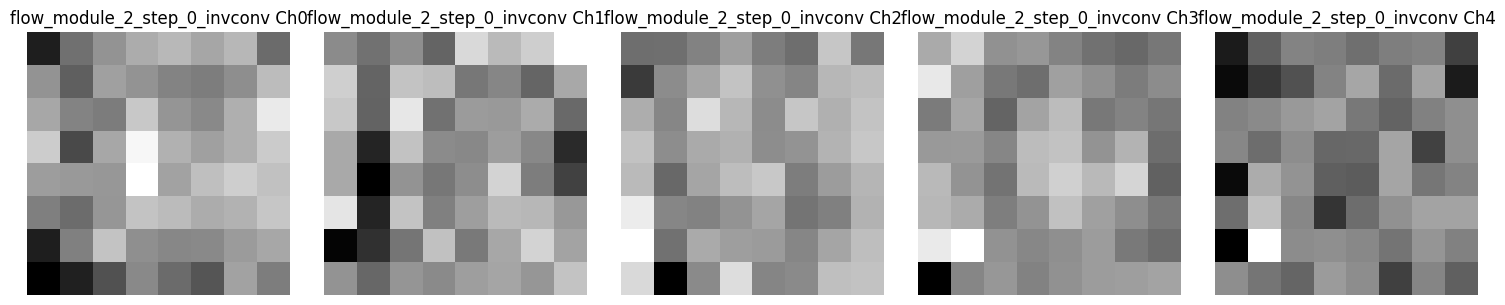

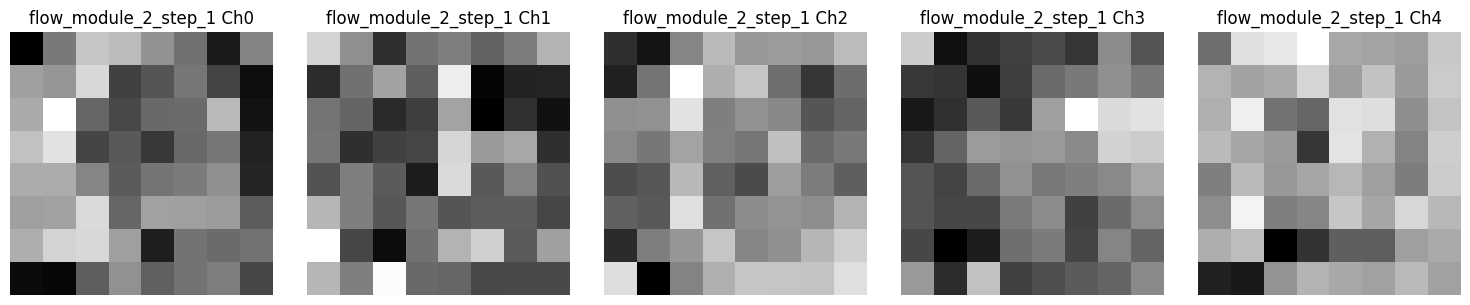

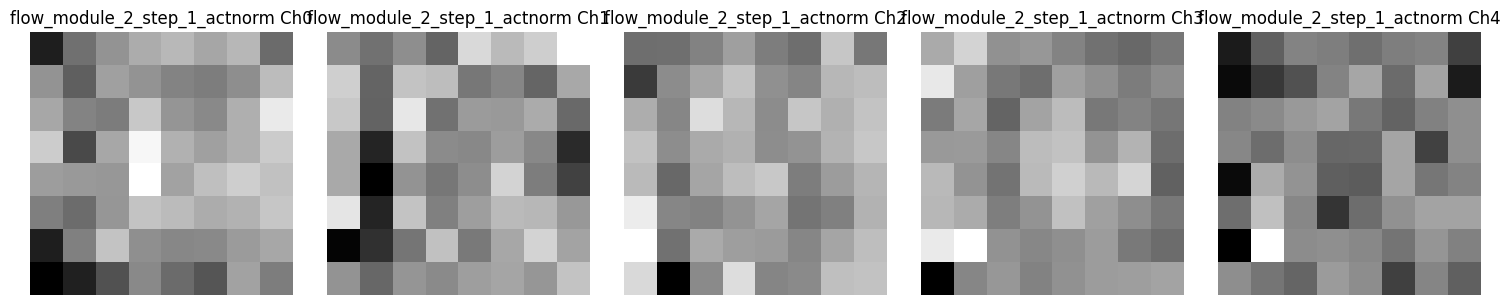

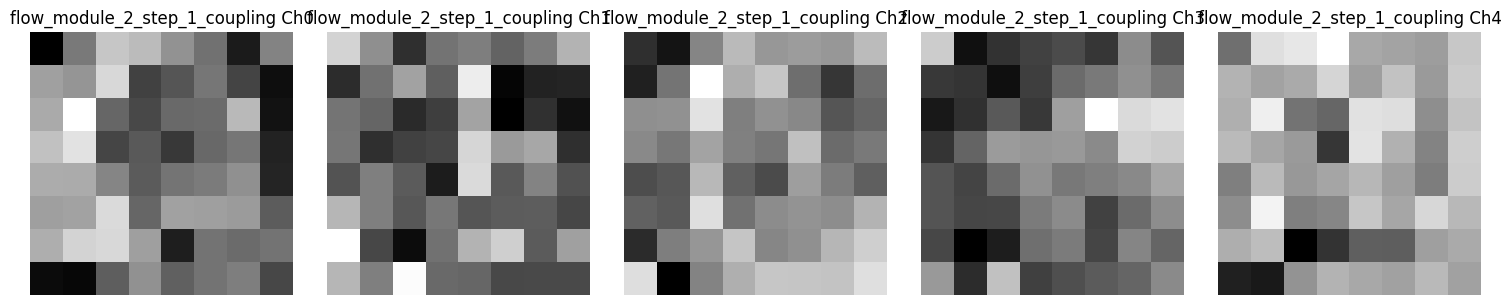

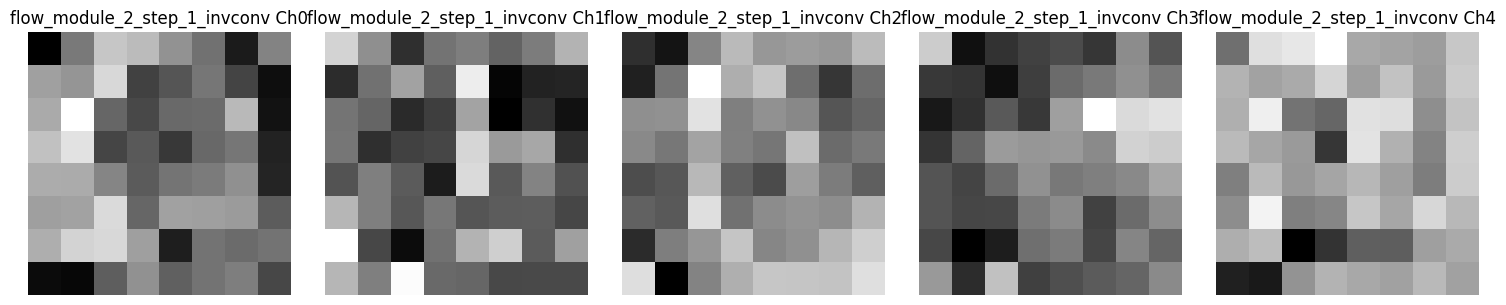

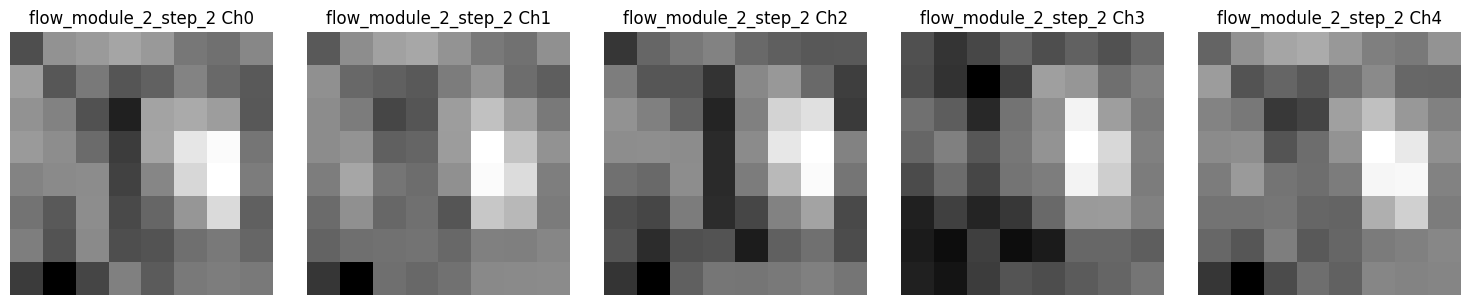

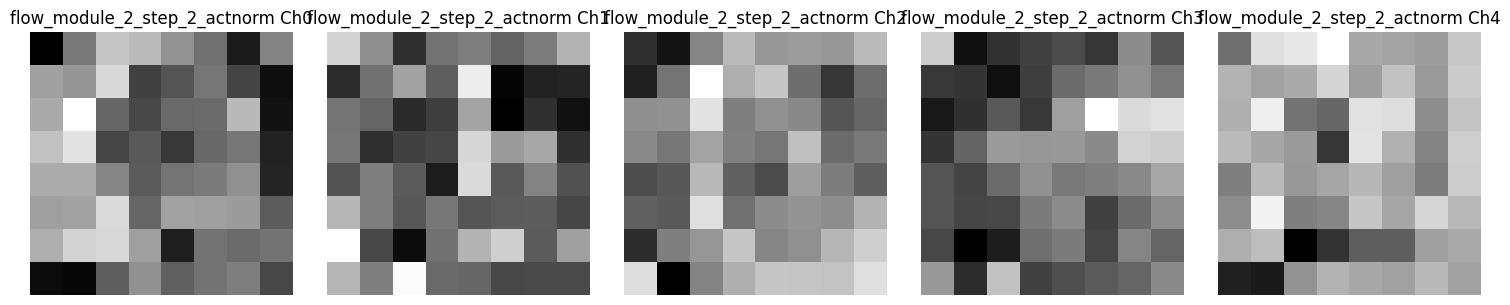

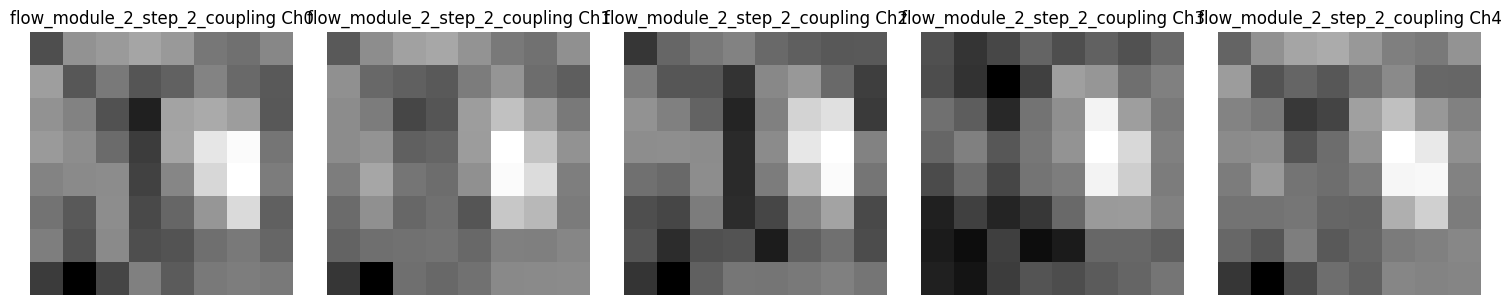

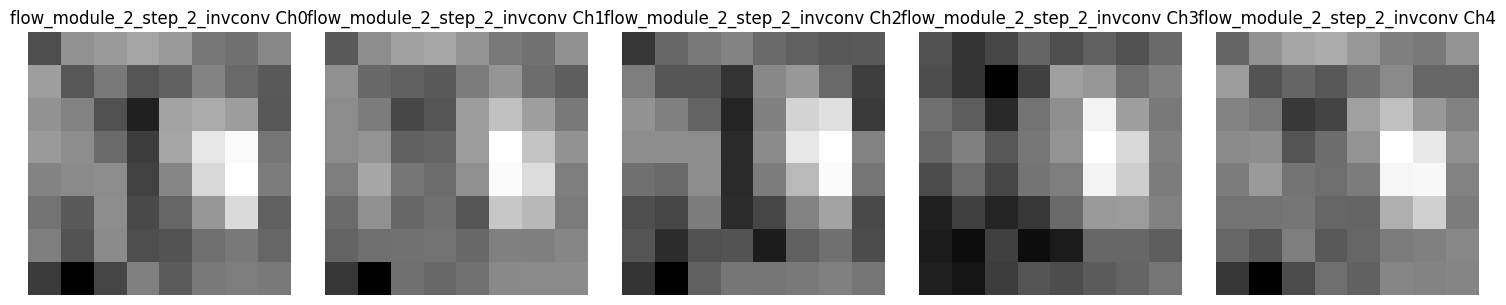

Generated Output:


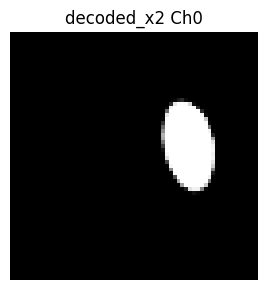

In [15]:
# # Example with dummy data
# x1 = torch.randn(1, 1, 64, 64).to(device)  # [B, C, H, W]
# x2 = torch.randn(1, 1, 64, 64).to(device)
visualize_model_outputs(model, x1_image, x2_image)

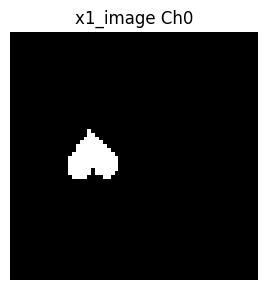

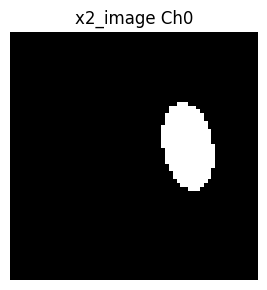

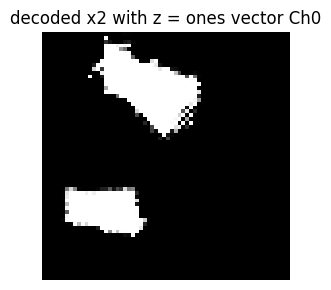

In [22]:

visualize_image_output(x1_image, 'x1_image')
visualize_image_output(x2_image, 'x2_image')

decoded_x2 = model.decoder(torch.ones([1, 10], dtype=torch.float32, device=device), x1_image)
visualize_image_output(decoded_x2, 'decoded x2 with z = ones vector')

tensor([[-9.3579e-06,  2.5034e-05, -5.3629e-04,  2.9823e-04,  1.3822e-04,
          6.3300e-05,  2.2566e-04, -3.4571e-05,  7.8678e-06,  7.8440e-05]],
       device='cuda:0', grad_fn=<SubBackward0>)


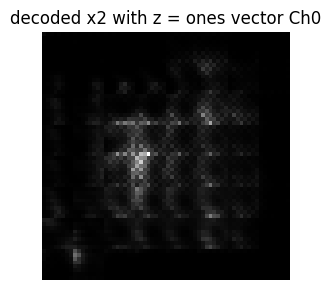

In [27]:

z, mu1, logvar, mu2, logvar2, =  model.encoder(x1_image, x1_image)
print(z)
decoded_x2 = model.decoder(z, x1_image)
visualize_image_output(decoded_x2, 'decoded x2 with z = ones vector')